In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/Project

/content/drive/MyDrive/Project


In [3]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from keras import backend as K
from keras.layers import Conv2D,MaxPooling2D,UpSampling2D,Input,BatchNormalization,LeakyReLU
from keras.layers.merge import concatenate
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras.models import load_model

tf.random.set_seed(123)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)
tf.random.set_seed(2)
np.random.seed(1)

# print(os.listdir("paintingdataset/dataset/dataset_updated/"))
print(os.listdir("landscapedataset/archive/intel-image-classification/train/"))

['glacier', 'street', 'sea', 'mountain', 'buildings', 'forest']


In [4]:
# ImagePath="paintingdataset/dataset/dataset_updated/training_set/painting/"
ImagePath="landscapedataset/archive/intel-image-classification/train/buildings/"


(224, 224, 3)

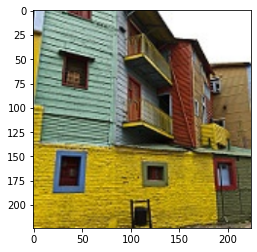

In [5]:
# img = cv2.imread(ImagePath+"1179.jpg")
img = cv2.imread(ImagePath + "4.jpg")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (224, 224))
plt.imshow(img)
img.shape

In [6]:
HEIGHT=224
WIDTH=224

def ExtractInput(path):
    X_img=[]
    y_img=[]
    for imageDir in os.listdir(ImagePath):
        try:
            img = cv2.imread(ImagePath + imageDir)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            # img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    
            img = img.astype(np.float32)
            img_lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
            #Convert the rgb values of the input image to the range of 0 to 1
            #1.0/255 indicates that we are using a 24-bit RGB color space.
            #It means that we are using numbers between 0–255 for each color channel
            #img_lab = 1.0/225*img_lab
            # resize the lightness channel to network input size 
            img_lab_rs = cv2.resize(img_lab, (WIDTH, HEIGHT)) # resize image to network input size
            img_l = img_lab_rs[:,:,0] # pull out L channel
            #img_l -= 50 # subtract 50 for mean-centering
            img_ab = img_lab_rs[:,:,1:]#Extracting the ab channel
            img_ab = img_ab/128
            #The true color values range between -128 and 128. This is the default interval 
            #in the Lab color space. By dividing them by 128, they too fall within the -1 to 1 interval.
            X_img.append(img_l)
            y_img.append(img_ab)
        except:
            pass
    X_img = np.array(X_img)
    y_img = np.array(y_img)
    
    return X_img,y_img

In [ ]:
X_,y_ = ExtractInput(ImagePath) # Data-preprocessing

In [7]:
K.clear_session()
def InstantiateModel(in_):
    model_ = Conv2D(16,(3,3),padding='same',strides=1)(in_)
    model_ = LeakyReLU()(model_)
    #model_ = Conv2D(64,(3,3), activation='relu',strides=1)(model_)
    model_ = Conv2D(32,(3,3),padding='same',strides=1)(model_)
    model_ = BatchNormalization()(model_)
    model_ = LeakyReLU()(model_)
    # model_ = BatchNormalization()(model_)
    model_ = MaxPooling2D(pool_size=(2,2),padding='same')(model_)
    
    model_ = Conv2D(64,(3,3),padding='same',strides=1)(model_)
    model_ = BatchNormalization()(model_)
    model_ = LeakyReLU()(model_)
    # model_ = BatchNormalization()(model_)
    model_ = MaxPooling2D(pool_size=(2,2),padding='same')(model_)
    
    model_ = Conv2D(128,(3,3),padding='same',strides=1)(model_)
    model_ = BatchNormalization()(model_)
    model_ = LeakyReLU()(model_)
    # model_ = BatchNormalization()(model_)

    model_ = Conv2D(256,(3,3),padding='same',strides=1)(model_)
    model_ = BatchNormalization()(model_)
    model_ = LeakyReLU()(model_)
    # model_ = BatchNormalization()(model_)
    
    model_ = UpSampling2D((2, 2))(model_)
    model_ = Conv2D(128,(3,3),padding='same',strides=1)(model_)
    model_ = BatchNormalization()(model_)
    model_ = LeakyReLU()(model_)
    # model_ = BatchNormalization()(model_)
    
    model_ = UpSampling2D((2, 2))(model_)
    model_ = Conv2D(64,(3,3), padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    #model_ = BatchNormalization()(model_)
    
    concat_ = concatenate([model_, in_]) 
    
    model_ = Conv2D(64,(3,3), padding='same',strides=1)(concat_)
    model_ = BatchNormalization()(model_)
    model_ = LeakyReLU()(model_)
    # model_ = BatchNormalization()(model_)
    
    model_ = Conv2D(32,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    #model_ = BatchNormalization()(model_)
    
    model_ = Conv2D(2,(3,3), activation='tanh',padding='same',strides=1)(model_)

    return model_

In [ ]:
# K.clear_session()
# def InstantiateModel(in_):
#     model_ = Conv2D(16,(3,3),padding='same',strides=1)(in_)
#     model_ = LeakyReLU()(model_)
#     #model_ = Conv2D(64,(3,3), activation='relu',strides=1)(model_)
#     model_ = Conv2D(32,(3,3),padding='same',strides=1)(model_)
#     model_ = LeakyReLU()(model_)
#     model_ = BatchNormalization()(model_)
#     model_ = MaxPooling2D(pool_size=(2,2),padding='same')(model_)
    
#     model_ = Conv2D(64,(3,3),padding='same',strides=1)(model_)
#     model_ = LeakyReLU()(model_)
#     model_ = BatchNormalization()(model_)
#     model_ = MaxPooling2D(pool_size=(2,2),padding='same')(model_)
    
#     model_ = Conv2D(128,(3,3),padding='same',strides=1)(model_)
#     model_ = LeakyReLU()(model_)
#     model_ = BatchNormalization()(model_)

#     model_ = Conv2D(256,(3,3),padding='same',strides=1)(model_)
#     model_ = LeakyReLU()(model_)
#     model_ = BatchNormalization()(model_)
    
#     model_ = UpSampling2D((2, 2))(model_)
#     model_ = Conv2D(128,(3,3),padding='same',strides=1)(model_)
#     model_ = LeakyReLU()(model_)
#     model_ = BatchNormalization()(model_)
    
#     model_ = UpSampling2D((2, 2))(model_)
#     model_ = Conv2D(64,(3,3), padding='same',strides=1)(model_)
#     model_ = LeakyReLU()(model_)
#     #model_ = BatchNormalization()(model_)
    
#     concat_ = concatenate([model_, in_]) 
    
#     model_ = Conv2D(64,(3,3), padding='same',strides=1)(concat_)
#     model_ = LeakyReLU()(model_)
#     model_ = BatchNormalization()(model_)
    
#     model_ = Conv2D(32,(3,3),padding='same',strides=1)(model_)
#     model_ = LeakyReLU()(model_)
#     #model_ = BatchNormalization()(model_)
    
#     model_ = Conv2D(2,(3,3), activation='tanh',padding='same',strides=1)(model_)

#     return model_

In [ ]:
Input_Sample = Input(shape=(HEIGHT, WIDTH,1))
Output_ = InstantiateModel(Input_Sample)
Model_Colourization = Model(inputs=Input_Sample, outputs=Output_)

In [ ]:
LEARNING_RATE = 0.001
Model_Colourization.compile(optimizer=Adam(lr=LEARNING_RATE),
                            loss='mean_squared_error')
Model_Colourization.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 224, 224, 16  0           ['conv2d[0][0]']                 
                                )                                                             

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
def GenerateInputs(X_,y_):
    for i in range(len(X_)):
        X_input = X_[i].reshape(1,224,224,1)
        y_input = y_[i].reshape(1,224,224,2)
        yield (X_input,y_input)
Model_Colourization.fit(GenerateInputs(X_,y_),epochs=50,verbose=1,steps_per_epoch=10,shuffle=True)#,validation_data=GenerateInputs(X_val, y_val))

Model_Colourization.save('buildings_colorization_model.h5')

Epoch 1/50
10/10 [==============================] - 19s 2s/step - loss: 0.1206
Epoch 2/50
10/10 [==============================] - 18s 2s/step - loss: 0.0241
Epoch 3/50
10/10 [==============================] - 18s 2s/step - loss: 0.0095
Epoch 4/50
10/10 [==============================] - 18s 2s/step - loss: 0.0081
Epoch 5/50
10/10 [==============================] - 18s 2s/step - loss: 0.0065
Epoch 6/50
10/10 [==============================] - 18s 2s/step - loss: 0.0041
Epoch 7/50
10/10 [==============================] - 18s 2s/step - loss: 0.0193
Epoch 8/50
10/10 [==============================] - 18s 2s/step - loss: 0.0050
Epoch 9/50
10/10 [==============================] - 18s 2s/step - loss: 0.0051
Epoch 10/50
10/10 [==============================] - 18s 2s/step - loss: 0.0045
Epoch 11/50
10/10 [==============================] - 18s 2s/step - loss: 0.0166
Epoch 12/50
10/10 [==============================] - 18s 2s/step - loss: 0.0159
Epoch 13/50
10/10 [==============================

In [8]:
Model_Colourization = load_model('colorization_model.h5')

Testing

In [9]:
# TestImagePath="paintingdataset/dataset/dataset_updated/training_set/iconography/"
# TestImagePath="landscapedataset/archive/intel-image-classification/validation/buildings/"
TestImagePath="fruitsdataset/archive/fruits-360_dataset/fruits-360/Test/Apple Braeburn/"


In [10]:
def ExtractTestInput(ImagePath):
    img = cv2.imread(ImagePath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img_ = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    img_ = cv2.cvtColor(img_, cv2.COLOR_RGB2Lab)
    img_=img_.astype(np.float32)
    img_lab_rs = cv2.resize(img_, (WIDTH, HEIGHT)) # resize image to network input size
    img_l = img_lab_rs[:,:,0] # pull out L channel
    #img_l -= 50
    img_l_reshaped = img_l.reshape(1,224,224,1)
    
    return img_l_reshaped

In [12]:
ImagePath=TestImagePath+"321_100.jpg"
image_for_test = ExtractTestInput(ImagePath)
Prediction = Model_Colourization.predict(image_for_test)
Prediction = Prediction*128
Prediction=Prediction.reshape(224,224,2)

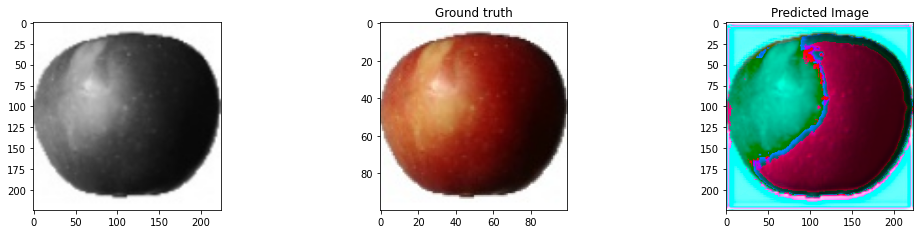

In [13]:
plt.figure(figsize=(30,20))
plt.subplot(5,5,1)
img = cv2.imread(TestImagePath+"321_100.jpg")
img_1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img_1, cv2.COLOR_RGB2GRAY)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
img = cv2.resize(img, (224, 224))
plt.imshow(img)

plt.subplot(5,5,1+1)
plt.title("Ground truth")
plt.imshow(img_1)

plt.subplot(5,5,1+2)
img_ = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
img_[:,:,1:] = Prediction
img_ = cv2.cvtColor(img_, cv2.COLOR_Lab2RGB)
plt.title("Predicted Image")
plt.imshow(img_)



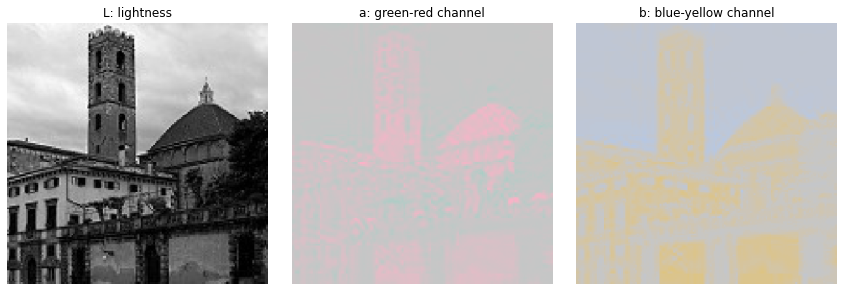

In [ ]:
from keras.preprocessing.image import  img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb
import matplotlib.pyplot as plt
import numpy as np

TestImagePath="landscapedataset/archive/intel-image-classification/validation/buildings/"
ImagePath=TestImagePath+"20061.jpg"
img = cv2.imread(TestImagePath+"20061.jpg")
# ImagePath = "landscapedataset/archive/intel-image-classification/train/street/184.jpg"
img = cv2.imread(ImagePath)


def extract_single_dim_from_LAB_convert_to_RGB(image,idim):
    '''
    image is a single lab image of shape (None,None,3)
    '''
    z = np.zeros(image.shape)
    if idim != 0 :
        z[:,:,0]=80 ## I need brightness to plot the image along 1st or 2nd axis
    z[:,:,idim] = image[:,:,idim]
    z = lab2rgb(z)
    return(z)

def plot_lab_spectrums():
    # Get image
    img = img_to_array(load_img(ImagePath,target_size=(400,400)))
    lab = rgb2lab(img/255.0)
    lab_l = extract_single_dim_from_LAB_convert_to_RGB(lab,0)
    lab_a = extract_single_dim_from_LAB_convert_to_RGB(lab,1)
    lab_db = extract_single_dim_from_LAB_convert_to_RGB(lab,2)

    # Plot the results
    fig, axes = plt.subplots(ncols=3, figsize=(12, 4))
    data = [('L: lightness', lab_l), ('a: green-red channel', lab_a), ('b: blue-yellow channel', lab_db)]

    for ax, (title, img) in zip(axes, data):
        ax.set_title(title)
        ax.imshow(img)
        ax.axis('off')

    fig.tight_layout()
    plt.show()

plot_lab_spectrums()